<a href="https://colab.research.google.com/github/RangerCoF/SparseConv/blob/main/MNIST/SparseConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device=cuda")
else:
    device = torch.device("cpu")
    print("device=cpu")

device=cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
class ConvNetDataset(Dataset):
  def __init__(self, data, targets, device):
    self.data = data.to(device)
    self.targets = targets.to(device)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data[idx]
    targets = self.targets[idx]
    return data, targets

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
traindata = []
traintargets = []
for sample in trainset:
  traindata.append(sample[0])
  traintargets.append(sample[1])

traindata = torch.stack(traindata, dim=0)
traintargets = torch.tensor(traintargets)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testdata = []
testtargets = []
for sample in testset:
  testdata.append(sample[0])
  testtargets.append(sample[1])

testdata = torch.stack(testdata, dim=0)
testtargets = torch.tensor(testtargets)

100%|██████████| 9912422/9912422 [00:00<00:00, 80432794.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34639889.57it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23325176.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14586928.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
prob = 0.5

trainmask = torch.bernoulli(torch.full(traindata.shape, 1 - prob))
trainset_input = torch.cat((traindata * trainmask, trainmask), dim=1)
trainset = ConvNetDataset(trainset_input, traintargets, device)

testmask = torch.bernoulli(torch.full(testdata.shape, 1 - prob))
testset_input = torch.cat((testdata * testmask, testmask), dim=1)
testset = ConvNetDataset(testset_input, testtargets, device)

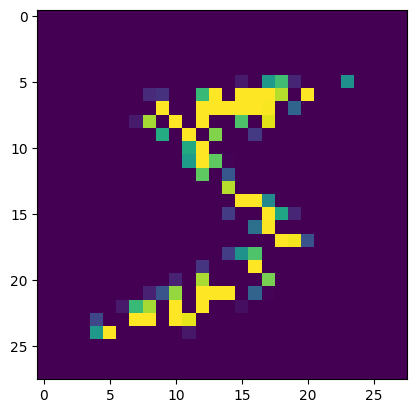

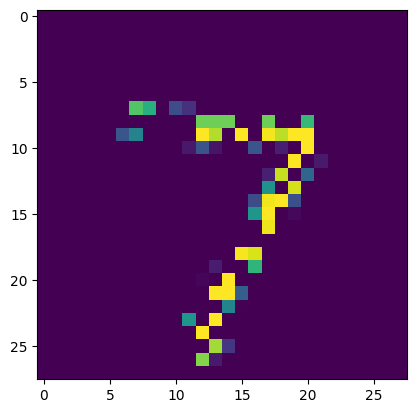

In [ ]:
plt.imshow(trainset[0][0].cpu().squeeze()[0, :, :])
plt.show()
plt.imshow(testset[0][0].cpu().squeeze()[0, :, :])
plt.show()

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0, pin_memory=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0, pin_memory=False)

In [ ]:
class SparseConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride=1,
      padding='same',
      dilation=1):
    super(SparseConvBlock, self).__init__()

    self.conv = nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=False)

    self.bias = nn.Parameter(
      torch.zeros(out_channels),
      requires_grad=True)

    self.sparsity = nn.Conv2d(
      in_channels=1,
      out_channels=1,
      kernel_size=kernel_size,
      padding=padding,
      dilation=dilation,
      bias=False)
    kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)
    self.sparsity.weight = nn.Parameter(
      data=kernel,
      requires_grad=False)

    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(2, 2)
    self.norm = nn.BatchNorm2d(out_channels)

  def forward(self, x, mask):
    x = self.conv(x * mask)
    normalizer = self.sparsity(mask) + 1e-8
    x = x / normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    x = self.relu(x)
    x = self.pool(x)
    x = self.norm(x)
    mask = self.pool(mask)
    return x, mask


In [ ]:
class SparseConvNet(nn.Module):
    def __init__(self):
      super(SparseConvNet, self).__init__()
      self.conv1 = SparseConvBlock(1, 6, 5, padding='same')
      self.conv2 = SparseConvBlock(6, 16, 5, padding='same')


      self.fc1 = nn.Linear(16 * 7 * 7, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      mask = x[:, -1:, :, :]
      x = x[:, :-1, :, :]

      x, mask = self.conv1(x, mask)

      x, mask = self.conv2(x, mask)
      # print(x.shape)
      # print(mask.shape)

      x = x.view(-1, 16 * 7 * 7)
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
net = SparseConvNet().to(device)
print(net)

SparseConvNet(
  (conv1): SparseConvBlock(
    (conv): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (sparsity): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (norm): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): SparseConvBlock(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (sparsity): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_feature

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in tqdm(range(2)):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs, labels = data
      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 2000 == 1999:
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
          running_loss = 0.0

print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]

[1,  2000] loss: 0.666
[1,  4000] loss: 0.280
[1,  6000] loss: 0.210
[1,  8000] loss: 0.177
[1, 10000] loss: 0.160
[1, 12000] loss: 0.151
[1, 14000] loss: 0.136


 50%|█████     | 1/2 [01:00<01:00, 60.60s/it]

[2,  2000] loss: 0.109
[2,  4000] loss: 0.102
[2,  6000] loss: 0.109
[2,  8000] loss: 0.105
[2, 10000] loss: 0.105
[2, 12000] loss: 0.103
[2, 14000] loss: 0.105


100%|██████████| 2/2 [01:57<00:00, 58.99s/it]

Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %
